# Training BERT, SciBERT and PubMedBERT

## 0. Setup

### 0.1 Install libraries

In [38]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [39]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1. Configuration

In [40]:
data_path = r"../../data/labeled/2025-06-28_labeled_data.xlsx"
text_column_name = "expanded"
label_column_name = "label_strict"

model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2
num_labels = 2

## 2. Read and prepare dataset

In [41]:
import pandas as pd

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance the dataset: all 1s and an equal number of random 0s
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0].sample(n=len(ones), random_state=42)
df = pd.concat([ones, zeros]).sample(frac=1, random_state=42).reset_index(drop=True)

# Show head
df.head()

,text,label
0,Change-detection RTs in Experiment 1 were not ...,1
1,"However, there was no difference between the a...",1
2,There was no significant interaction between p...,0
3,The overall interaction effect of Sex Ratio Ã—...,0
4,We also examined whether individual difference...,0


### 2.1 Create Train/Test set

In [42]:
from sklearn.model_selection import train_test_split

# Separate by label
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0]

# Split each class into train/test
ones_train, ones_test = train_test_split(ones, test_size=test_size, random_state=42)
zeros_train, zeros_test = train_test_split(zeros, test_size=test_size, random_state=42)

# Combine to make balanced train/test sets
df_train = pd.concat([ones_train, zeros_train]).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat([ones_test, zeros_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

Header of the Training set:

In [43]:
df_train.head()

,text,label
0,"Most importantly, however, the baseline-to-pea...",1
1,Cortisol concentrations were comparable at bas...,1
2,The main effect of workload was not significan...,0
3,Analyzing men and women separately revealed a ...,0
4,"Moreover, using markers of higher-quality list...",0


In [44]:
# Check label balance in training set
df_train['label'].value_counts()

label
1    112
0    112
Name: count, dtype: int64

Header of the Test set:

In [45]:
df_test.head()

,text,label
0,The response latencies of the low-AQ and high-...,1
1,Risk taking did not differ between participant...,1
2,Although the PTSD group showed a significant f...,0
3,Participants of the stress groups (vs. control...,1
4,There was no main effect of channel-group late...,1


In [46]:
# Check label balance in test set
df_test['label'].value_counts()

label
1    28
0    28
Name: count, dtype: int64

### 2.2 Tokenize 'text'

In [47]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=350)

tokenized_train = train_dataset.map(preprocess_function, batched=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 56/56 [00:00<00:00, 3374.00 examples/s]


#### 2.2.1 Comparing tokenized and untokenized statements

In [48]:
# Collect comparison data for the first 20 samples (adjust as needed)
comparison = []
for i in range(224):
    original = train_dataset[i]['text']
    input_ids = tokenized_train[i]['input_ids']
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
    comparison.append({
        "original_text": original,
        "tokenized_ids": input_ids,
        "decoded_text": decoded
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison)

# Show header
df_comparison.head(10)

# Save to CSV
# df_comparison.to_csv("tokenization_comparison.csv", index=False)
# print("Saved as tokenization_comparison.csv")

,original_text,tokenized_ids,decoded_text
0,"Most importantly, however, the baseline-to-pea...","[101, 2087, 14780, 1010, 2174, 1010, 1996, 261...","most importantly, however, the baseline - to -..."
1,Cortisol concentrations were comparable at bas...,"[101, 2522, 28228, 19454, 14061, 2020, 12435, ...",cortisol concentrations were comparable at bas...
2,The main effect of workload was not significan...,"[101, 1996, 2364, 3466, 1997, 2147, 11066, 200...",the main effect of workload was not significan...
3,Analyzing men and women separately revealed a ...,"[101, 20253, 2273, 1998, 2308, 10329, 3936, 10...",analyzing men and women separately revealed a ...
4,"Moreover, using markers of higher-quality list...","[101, 9308, 1010, 2478, 16387, 1997, 3020, 101...","moreover, using markers of higher - quality li..."
5,"Likewise, the difference in mean GPS between t...","[101, 10655, 1010, 1996, 4489, 1999, 2812, 146...","likewise, the difference in mean gps between t..."
6,The effect of block was driven by slower respo...,"[101, 1996, 3466, 1997, 3796, 2001, 5533, 2011...",the effect of block was driven by slower respo...
7,There was no difference in the ratings given t...,"[101, 2045, 2001, 2053, 4489, 1999, 1996, 8599...",there was no difference in the ratings given t...
8,"Furthermore, the effect of channel-group later...","[101, 7297, 1010, 1996, 3466, 1997, 3149, 1011...","furthermore, the effect of channel - group lat..."
9,"In contrast, non-White AI faces (left side of ...","[101, 1999, 5688, 1010, 2512, 1011, 2317, 9932...","in contrast, non - white ai faces ( left side ..."


## 3. Regular BERT

### 3.1 Initializing regular BERT

In [49]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [50]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_10340\617370419.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [51]:
trainer_bert.train()

Step,Training Loss
28,0.714200
56,0.679700
84,0.631900
112,0.525600
140,0.433000


TrainOutput(global_step=140, training_loss=0.5968748569488526, metrics={'train_runtime': 47.6119, 'train_samples_per_second': 23.524, 'train_steps_per_second': 2.94, 'total_flos': 159428855107200.0, 'train_loss': 0.5968748569488526, 'epoch': 5.0})

#### 3.2.1 Save last model

In [52]:
# trainer_bert.save_model('bert_model')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [53]:
from sklearn.metrics import classification_report

preds = trainer_bert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       112
           1       0.91      0.96      0.93       112

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224



#### 3.3.2 Predict test data

In [54]:
preds = trainer_bert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74        28
           1       0.77      0.61      0.68        28

    accuracy                           0.71        56
   macro avg       0.72      0.71      0.71        56
weighted avg       0.72      0.71      0.71        56



#### 3.3.3 4.3.3 Confusion-Matrix for test data

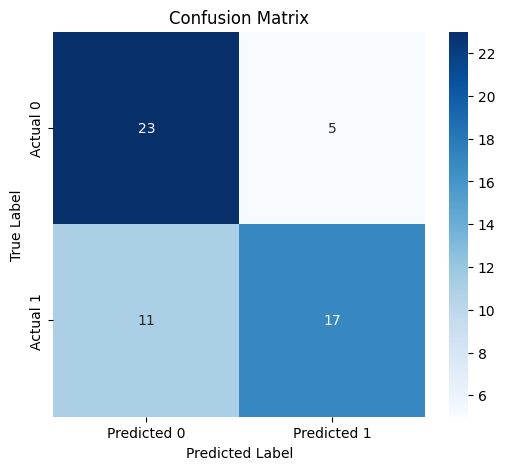

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [56]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [57]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 17)


,text
0,Participants of the stress groups (vs. control...
1,There was no main effect of channel-group late...
2,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
3,Consistent with study hypotheses emphasizing t...
4,There was a significant effect of feeling smal...
5,Paired t tests showed that only for the neutra...
6,The results indicate that both participants in...
7,Follow-up analyses showed that there was no Tr...
8,Adding delay (15 s and 30 s) in the second mod...
9,"As in Study 1, individuals' risk and social pr..."


In [58]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 23)


,text
0,Although the PTSD group showed a significant f...
1,"Overall, RT was on average slower when sounds ..."
2,"We found a significant main effect of outcome,..."
3,The percentage of children who waited for the ...
4,Results revealed no significant relationship b...
5,"Conversely, the interaction between KoR and SO..."
6,Participants in the ultimatum game were nonsig...
7,"The dyslexia (M = .87, SD = .05) and control (..."
8,"In the current meta-analysis, however, there w..."
9,"Here, too, the interaction effects were nonsig..."


In [59]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 5)


,text
0,"For the recognition data, the NHST analysis sh..."
1,"When we compared directly, we found that in ne..."
2,The main effect of congruence did not reach si...
3,"Regarding the main effect of task, smaller P1 ..."
4,"For the mid-scale questions, we found no diffe..."


In [60]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 11)


,text
0,The response latencies of the low-AQ and high-...
1,Risk taking did not differ between participant...
2,"For relative changes in pupil size, we obtaine..."
3,Correlations between dizygotic twins did not d...
4,Accuracy (proportion of correct responses) did...
5,There were no differences between groups in ov...
6,"First, participant height (added as a fixed fa..."
7,We next focused on report error and found a ma...
8,"Similarly, for inverted scenes, categorization..."
9,"However, there was no performance difference b..."


## 4. SciBERT

### 4.1 Initializing SciBERT

In [61]:
from transformers import AutoModelForSequenceClassification

model_scibert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Training SciBERT

In [62]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_scibert = Trainer(
    model=model_scibert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_10340\2136063693.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_scibert = Trainer(


In [63]:
trainer_scibert.train()

Step,Training Loss
28,0.732700
56,0.707200
84,0.648400
112,0.552500
140,0.411500


TrainOutput(global_step=140, training_loss=0.6104704993111747, metrics={'train_runtime': 54.7121, 'train_samples_per_second': 20.471, 'train_steps_per_second': 2.559, 'total_flos': 159428855107200.0, 'train_loss': 0.6104704993111747, 'epoch': 5.0})

#### 4.2.1 Save last model

In [64]:
# trainer_scibert.save_model('scibert_model')

### 4.3 Evaluate model

#### 4.3.1 Predict training data

In [65]:
from sklearn.metrics import classification_report

preds = trainer_scibert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       112
           1       0.96      0.92      0.94       112

    accuracy                           0.94       224
   macro avg       0.94      0.94      0.94       224
weighted avg       0.94      0.94      0.94       224



#### 4.3.2 Predict test data

In [66]:
preds = trainer_scibert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75        28
           1       0.80      0.57      0.67        28

    accuracy                           0.71        56
   macro avg       0.73      0.71      0.71        56
weighted avg       0.73      0.71      0.71        56



#### 4.3.3 Confusion-Matrix for test data

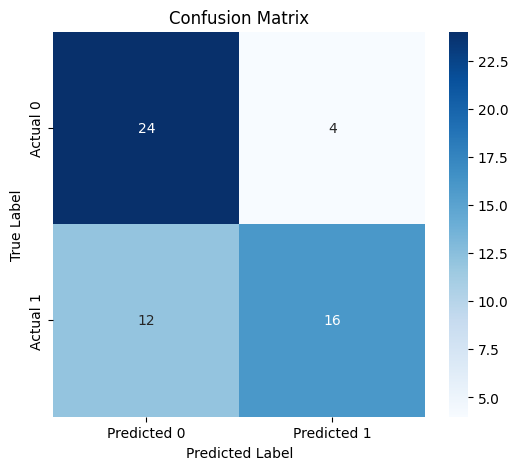

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 4.3.4 List of statements per category (TP, TN, FP, FN)

In [68]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [69]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 16)


,text
0,The response latencies of the low-AQ and high-...
1,Participants of the stress groups (vs. control...
2,There was no main effect of channel-group late...
3,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
4,Consistent with study hypotheses emphasizing t...
5,The results indicate that both participants in...
6,"For relative changes in pupil size, we obtaine..."
7,Follow-up analyses showed that there was no Tr...
8,Adding delay (15 s and 30 s) in the second mod...
9,"As in Study 1, individuals' risk and social pr..."


In [70]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 24)


,text
0,"Overall, RT was on average slower when sounds ..."
1,"We found a significant main effect of outcome,..."
2,Results revealed no significant relationship b...
3,"Conversely, the interaction between KoR and SO..."
4,Participants in the ultimatum game were nonsig...
5,"The dyslexia (M = .87, SD = .05) and control (..."
6,"For the recognition data, the NHST analysis sh..."
7,"In the current meta-analysis, however, there w..."
8,"When we compared directly, we found that in ne..."
9,"Here, too, the interaction effects were nonsig..."


In [71]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 4)


,text
0,Although the PTSD group showed a significant f...
1,The percentage of children who waited for the ...
2,There was not a significant difference between...
3,The interaction between familiarity and length...


In [72]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 12)


,text
0,Risk taking did not differ between participant...
1,There was a significant effect of feeling smal...
2,Paired t tests showed that only for the neutra...
3,Correlations between dizygotic twins did not d...
4,Accuracy (proportion of correct responses) did...
5,There were no differences between groups in ov...
6,"First, participant height (added as a fixed fa..."
7,When participants made large errors on previou...
8,"Similarly, for inverted scenes, categorization..."
9,A control model additionally revealed a main e...


## 5. PubMedBERT

### 5.1 Initializing PubMedBERT

In [73]:
from transformers import AutoModelForSequenceClassification

model_pubmedbert = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Training PubMedBERT

In [74]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_pubmedbert = Trainer(
    model=model_pubmedbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_10340\2526163365.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [75]:
trainer_pubmedbert.train()

Step,Training Loss
28,0.749600
56,0.692200
84,0.588600
112,0.403400
140,0.267200


TrainOutput(global_step=140, training_loss=0.5401743820735386, metrics={'train_runtime': 55.1234, 'train_samples_per_second': 20.318, 'train_steps_per_second': 2.54, 'total_flos': 159428855107200.0, 'train_loss': 0.5401743820735386, 'epoch': 5.0})

#### 5.2.1 Save last model

In [76]:
# trainer_pubmedbert.save_model('pubmedbert_model')

### 5.3 Evaluate model

#### 5.3.1 Predict training data

In [77]:
from sklearn.metrics import classification_report

preds = trainer_pubmedbert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       112
           1       0.95      0.96      0.95       112

    accuracy                           0.95       224
   macro avg       0.95      0.95      0.95       224
weighted avg       0.95      0.95      0.95       224



#### 5.3.2 Predict test data

In [78]:
preds = trainer_pubmedbert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67        28
           1       0.67      0.71      0.69        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



#### 5.3.3 Confusion-Matrix for test data

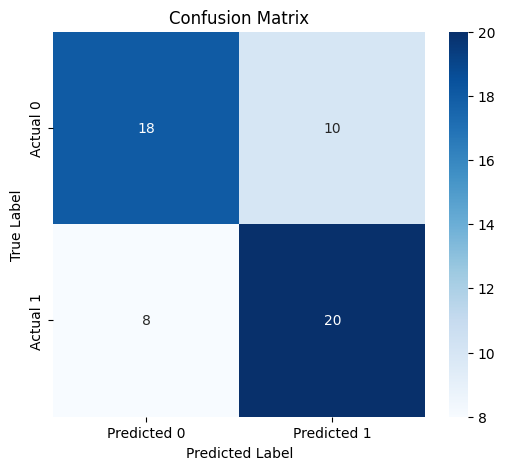

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 5.3.4 List of statements per category (TP, TN, FP, FN)

In [80]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [81]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 20)


,text
0,The response latencies of the low-AQ and high-...
1,Participants of the stress groups (vs. control...
2,There was no main effect of channel-group late...
3,"Distance, Ï‡ 2 (1, N = 32) = 1.52, p = .217, d..."
4,Consistent with study hypotheses emphasizing t...
5,There was a significant effect of feeling smal...
6,The results indicate that both participants in...
7,"For relative changes in pupil size, we obtaine..."
8,Follow-up analyses showed that there was no Tr...
9,Correlations between dizygotic twins did not d...


In [82]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 18)


,text
0,Although the PTSD group showed a significant f...
1,"Overall, RT was on average slower when sounds ..."
2,The percentage of children who waited for the ...
3,Results revealed no significant relationship b...
4,"Conversely, the interaction between KoR and SO..."
5,"The dyslexia (M = .87, SD = .05) and control (..."
6,"When we compared directly, we found that in ne..."
7,"In all these models, women were more likely to..."
8,There was no significant Visual Cue Ã— Valence...
9,The moderator tests were nonsignificant for bo...


In [83]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 10)


,text
0,"We found a significant main effect of outcome,..."
1,Participants in the ultimatum game were nonsig...
2,"For the recognition data, the NHST analysis sh..."
3,"In the current meta-analysis, however, there w..."
4,"Here, too, the interaction effects were nonsig..."
5,Withinpair linear regressions in identical twi...
6,There was not a significant difference between...
7,The effect of ValenceDiff varied significantly...
8,"Similarly, within-pair analyses in identical p..."
9,"For the mid-scale questions, we found no diffe..."


In [84]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 8)


,text
0,Risk taking did not differ between participant...
1,Paired t tests showed that only for the neutra...
2,There were no differences between groups in ov...
3,"As in Study 1, individuals' risk and social pr..."
4,We next focused on report error and found a ma...
5,A control model additionally revealed a main e...
6,Unlike the analyses using RT on search trials ...
7,"Furthermore, we found that the nudge was effec..."


In [ ]:
# The end...